Trong module trước, chúng ta đã xây dựng mô hình CNN cho 2 class và nhiều class. Mỗi mô hình đều có khả năng học dữ liệu train khác nhau, nhưng nhìn chung khả năng học chưa tốt, vẫn cần phải cải thiện rất nhiều. Để cải thiện mô hình, có rất nhiều cách khác nhau mà chúng ta đã thử ở cuối module trước. Trong số những cách đó có đề cập đến **transfer learning** nhưng vẫn chưa được sử dụng. 

Trong module này, chúng ta sẽ tập trung việc xây dựng và cải thiện mô hình với **transfer learning** để xem liệu nó có đem lại một điều gì đó tốt hơn cho mô hình dự đoán hay không. 

Nội dung phần 1 bao gồm : 

1. Giới thiệu về **Transfer learning** 
2. Giới thiệu các hàm callback để giám sát mô hình train
3. Sử dụng tập dữ liệu nhỏ để thử nghiệm nhanh khả năng học của mô hình
  + 3.1 Xây dựng mô hình dựa trên RestnetV50
  + 3.2 Xây dựng mô hình dựa trên EfficientNetB0
  + 3.3 Xây dựng mô hình dựa trên ImageNet
4. Sử dụng tensorboard để so sánh kết quả từ các mô hình
  + 4.1 Upload các thử nghiệm lên TensorBoard
  + 4.2 Liệt kê các thử nghiệm đã được lưu trên Tensorboard
  + 4.3 Xóa thử nghiệm trong tensorboard

> 🔑**Lưu ý** : Với những kiểu dữ liệu hình ảnh hoặc dữ liệu có cấu trúc phức tạ như âm thanh, giọng nói thì chúng ta nên sử dụng GPU thay vì CPU để cải thiện tốc độ xử lý cho mô hình.

Trước tiên kiểm tra xem notebook có sử dụng GPU chưa 

In [ ]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-a5436447-c0aa-234f-06b6-4012ea6f8efe)


Nếu thông báo `NVIDIA-SMI has failed ....` thì GPU không hoạt động, còn nếu có tên loại GPU như `GPU 0: Tesla [K80, T4, P4]` thì nó đang hoạt động.

## 1. Giới thiệu về Transfer learning


> 📖 Định nghĩa **Transfer learning** : là một kỹ thuật vận dụng những kỹ năng, tri thức (cũng được gọi là `weights`) của mô hình cho ứng dụng này để áp dụng xử lý những vấn đề cho một ứng khác. VD: Bạn học tốt môn toán, xác suất, thống kê thì có thể  lấy kiến thức đó để giải quyết cho vấn đề phân tích dữ liệu, cho ngành học máy. 

Có 2 ưu điểm lợi khi sử transfer learning: 

- Có thể tận dụng lại kiến trúc CNN đã được xây dựng trước đó để giải quyết các vấn đề tương tự trong ứng dụng đang xây dựng
- Có thể tận dung lại kiến trúc CNN đã được **học** những kỹ nắng, tri thức trên tập dữ liệu tương tự như tập dữ liệu của chúng ta. Điều này thường đem lại kết quả tốt cho mô hình học với dữ liệu chúng ta đưa vào không cần quá lớn.

Điều này có nghĩa là thay vì phải tự tay xây dựng mô hình CNN ngay từ đầu, chúng ta có thể tái sử dụng lại mô hình đã được ai đó xây dựng trước. Và thay vì phải train mô hình với tập dữ không đủ lớn, chúng ta có tận dụng lại những kiến thức của một mô hình đã được học từ một tập dữ liệu khổng lồ như là  [ImageNet](http://www.image-net.org/) (với hàng triệu hình ảnh liên quan đến những đối tượng khác nhau). Do đó, sử dụng kỹ thuật này sẽ đem lại kết quả tốt đối với lượng dữ liệu nhỏ hơn. 

## 2. Sử dụng tập dữ liệu nhỏ để thử nghiệm nhanh khả năng học của mô hình

Khi sử dụng Deep learning để giải quyết một vấn đề nào đó, rất có thể trước bạn đã có nhiều người đã xây dựng mô hình để giải quyết vấn đề bạn đang gặp phải. Và một thông tin tốt là bạn có thể tiếp cận được với nhiều mô hình đã được xây dựng trước đó tại [TensorFlow Hub](https://tfhub.dev/). Đây là một kho lưu trữ rất nhiều mô hình được train sẵn, nó giúp bạn có thể import về và kết nối đến những mô hình này một cách đầy đủ chỉ với đường dẫn liên kết (URL) đến vị trí của mô hình được lưu trữ đó. 

Như ở mục trên đã nói về ưu điểm của transfer learning, nó không cần sử dụng quá nhiều dữ liệu nhưng mô hình học vẫn rất tốt. Để chứng minh cho điều này, chúng ta chỉ cần lấy 10% dữ liệu gốc để train mô hình. 

Ở `module_4 : preprocessing data`, môt class có 1000 hình ảnh với 750 hình ảnh `train`, 250 để `test`. Nên Với 10% dữ liệu `train`, chúng ta chỉ cần đưa 75 hình vào mô hình train là được. 


![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/04-transfer-learning-feature-extraction.png)

Chúng ta sẽ tải 10% dữ liệu của 10 class và tiến hành train mô hình với **transfer learning**


In [ ]:
!wget https://www.dropbox.com/s/mkm0q76ng7uy430/10_food_classes_10_percent.zip

--2021-09-08 17:12:20--  https://www.dropbox.com/s/mkm0q76ng7uy430/10_food_classes_10_percent.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6030:18::a27d:5012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/mkm0q76ng7uy430/10_food_classes_10_percent.zip [following]
--2021-09-08 17:12:20--  https://www.dropbox.com/s/raw/mkm0q76ng7uy430/10_food_classes_10_percent.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc648a6571a2a3836ef132a3fdff.dl.dropboxusercontent.com/cd/0/inline/BVxtFf7MAATXB4EHVbFacwrJvOdgOrM_N_HD0aHom0Di_Up0KRhrZFDssOgRE-A1LID5TQafFB8UTcIhUu-0G_PIrl9LzvsueXmOPwJAs208b0chwfRL9Lcl70lqf9vdjf6uOikzSxT5gIwDWmEtPhXn/file# [following]
--2021-09-08 17:12:20--  https://uc648a6571a2a3836ef132a3fdff.dl.dropboxusercontent.com/cd/0/inline/BVxtFf7MAATXB4EHVbFacwrJvOdgOrM_N_H

In [ ]:
# Để giúp cho notebook được gọn gàng hơn, chúng ta sẽ tạo một class tên là helper để xử lý các dữ liệu và các
# gọi lại các hàm có thể tái sử dụng 
import os 
import zipfile
import matplotlib.pyplot as plt
class HelperFunctions(): 
  def unzip_file(self, filepath) : 
    zipref = zipfile.ZipFile(filepath)
    zipref.extractall()
    zipref.close()
    print("Unzipped File")
  def walk_through_directory(self, dirpath)  :
    for pathname, dirnames, filenames in os.walk(dirpath) : 
      print(f"Có {len(dirnames)} folder và {len(filenames)} files trong thư mục {pathname}")
  def plot_loss_curves(self, model_history) : 
    history = model_history.history
    acc,val_acc = history["accuracy"], history["val_accuracy"]
    loss, val_loss = history["loss"], history["val_loss"]

    plt.figure(figsize=(16,6))
    plt.subplot(121)
    plt.plot(acc, label="train accuracy")
    plt.plot(val_acc, label="val accuracy")
    plt.title("Accuracy")
    plt.legend()

    plt.subplot(122)
    plt.plot(loss,label="train loss")
    plt.plot(val_loss, label="val loss")
    plt.title("loss")
    plt.legend()

helper_functions = HelperFunctions()    

In [ ]:
helper_functions.unzip_file("10_food_classes_10_percent.zip")

Unzipped File


In [ ]:
helper_functions.walk_through_directory("10_food_classes_10_percent")

Có 2 folder và 0 files trong thư mục 10_food_classes_10_percent
Có 10 folder và 0 files trong thư mục 10_food_classes_10_percent/train
Có 0 folder và 75 files trong thư mục 10_food_classes_10_percent/train/panna_cotta
Có 0 folder và 75 files trong thư mục 10_food_classes_10_percent/train/prime_rib
Có 0 folder và 75 files trong thư mục 10_food_classes_10_percent/train/clam_chowder
Có 0 folder và 75 files trong thư mục 10_food_classes_10_percent/train/greek_salad
Có 0 folder và 75 files trong thư mục 10_food_classes_10_percent/train/spaghetti_bolognese
Có 0 folder và 75 files trong thư mục 10_food_classes_10_percent/train/filet_mignon
Có 0 folder và 75 files trong thư mục 10_food_classes_10_percent/train/garlic_bread
Có 0 folder và 75 files trong thư mục 10_food_classes_10_percent/train/pulled_pork_sandwich
Có 0 folder và 75 files trong thư mục 10_food_classes_10_percent/train/pad_thai
Có 0 folder và 75 files trong thư mục 10_food_classes_10_percent/train/bruschetta
Có 10 folder và 0 fil

### Đồng bộ và chuẩn hóa dữ liệu (Xử lý dữ liệu trước khi đưa vào mô hình)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical"
)

test_data =  test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical"
)

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


Dữ liệu đã được đồng bộ và chuẩn hóa. Nhưng trước khi xây dựng mô hình, chúng ta sẽ thiết lập một số công cụ để giám sát quá trình train của mô hình. 

## 2. Giới thiệu các hàm callback để giám sát mô hình train 

[Callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks) là một hàm bổ sung được thêm vào mô hình để theo dõi quá trình train của nó, các hàm này ghi lại những thay đổi của mô hình theo như yêu cầu. Một số hàm callbacks được sử dụng phổ biến để theo dõi mô hình train là : 

+ [**Experiment tracking with TensorBoard**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard) : Ghi lại nhật ký hoạt động của nhiều mô hình, sau đó xem và so sánh các mô hình này một cách trực quan trên TensorBoard ( một bảng điều khiển để giám sát các neural network). Sử dụng callbacks này hữu ích khi so sánh kết quả của các mô hình khác nhau cùng train trên một tập dữ liệu. 
+  [**Model checkpointing**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) : Khi mô hình đang hoạt động bạn có thể ngưng lại đột ngột và có thể quay lại tiếp tục train mô hình tại nơi đã bị ngắt, không phải bắt đầu lại từ đầu. Điều này rất hữu ích đối với mô hình train mất nhiều thời gian hoặc không thể train toàn bộ trong 1 lần. 
+ [**Early stopping**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) : Để mô hình có thể train trong một khoảng thời gian tùy ý (bao nhiêu epoch cũng được). Khi nó train đến một thời điểm nào đó không còn khả năng tiến bộ nữa thì sẽ ngắt không học nữa. Điều này hữu ích khi bạn có tập dữ liệu lớn và quá trình train đủ lâu 

Trước tiên, chúng ta sẽ sử dụng Tensorboard Callback ([`tf.keras.callbacks.TensorBoard()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard). Chức nắng chính của nó là lưu giữ quá trình hoạt động của mô hình train vào một đường dẫn  `log_dir` cụ thể mà ta chỉ đến. Theo mặc định, sau mỗi epoch thì nó sẽ tự động ghi vào log quá trình hoạt động của mô hình tại epoch đó, thể hiện qua tham số `update_freq='epoch'`. Sự theo dõi này sẽ làm cho quá trình train mô hình chậm hơn vì nó phải mất thời gian để ghi lại quá trình này vào log. 



In [ ]:
import datetime 
def create_tensorboard_callback(dir_name, experiment_name) : 
  log_dir = os.path.join(dir_name, experiment_name, datetime.datetime.now().strftime("%d%m%Y-%H%M%S"))
  tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir)
  print(f"Đã lưu tensorboard callback vào : {log_dir}")
  return tensorboard_cb

Bởi vì có thể chạy nhiều thử nghiệm nên chúng ta sẽ tạo logs ghi lại quá trình hoạt động của mô hình theo đường dẫn `[dir_name]/[experiment_name]/[current_timestamp]` với : 

+ `dir_name` : Đường dẫn gốc cho toàn bộ log
+ `experiment_name` : Tên mô hình thử nghiệm 
+ `current_timestamp` : Thời gian thử nghiệm mô hình

Do có thể cùng một mô hình nhưng thử nghiệm nhiều lần nên ta sẽ sử dụng thời gian để nhận dạng cho tưng thử nghiệm đó.

### Tạo mô hình sử dụng Tensorflow Hub 

Trước đây, để tạo mô hình chúng ta sử dụng tensorflow để khởi tạo mô hình liên kết giữa các layer với nhau. Với [TensorFlow Hub](https://tfhub.dev/), quá trình xử lý này cũng tương tự ngoại trừ phần lớn các layer đã được dựng sẵn trong nó.

Chúng ta sẽ trải nghiệm với 3 mô hình từ [TensorFlow Hub](https://tfhub.dev/) : 


1. [ResNetV2](https://arxiv.org/abs/1603.05027) -  Một kiến trúc mô hình thị giác máy hiện đại tính từ 2016.
2. [EfficientNet](https://arxiv.org/abs/1905.11946) - Một kiến trúc mô hình thị giác máy tính hiện đại từ 2019.
3. [ImageNet](https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/classification/5) 

Hiện đại có nghĩa là tại một số thời điểm, cả 2 mô hình đã đạt tỉ lệ lỗi thấp nhất trên [ImageNet (ILSVRC-2012-CLS)](http://www.image-net.org/), một tiêu chuẩn vàng cho việc đánh giá trong thị giác máy tính

Làm như thế nào để tìm được mô hình phù hợp trên Tensorflow hub?

Đây là một vài bước bạn có thể tham khảo : 

1. Truy cập [tfhub.dev](https://tfhub.dev/)
2. Lựa chọn `Problem domain` cần giải quyết, hiện tại chúng ta đang làm việc với hình ảnh nên chọn `Image` 
3. Sẽ có rất nhiều `Problem domain` hiện lên, tùy thuộc vào trường hợp nào mà ta sẽ chọn để nó Tensorflow Hub lọc cho ta, ở đây chúng ta đang làm việc với phân loại hình ảnh nên chọn `Image Classification` còn lại chúng ta sẽ bỏ đi. **Lưu ý** : `Image feature vector` **đừng bỏ** vì nó có thể được sử dụng trong mọi vấn đề. 
4. Các mô hình được liệt kê là tất cả những mô hình có khả năng được sử dụng để giải quyết vấn đề của chúng ta

> 🤔 **Câu hỏi:** *Tôi thấy có rất nhiều lựa chọn, làm sao biết được cái nào là tốt nhất?* 

Bạn có thể xem lượt tải của các mô hình, càng lớn thì có nghĩa có nhiều người sử  dụng nó hoặc các mô hình hiện đại đạt độ chính xác cao trên [paperswithcode.com](https://www.paperswithcode.com), một mã nguồn thu thập các kết quả train mô hình deep learning mới nhất được ghi lại trong các bản báo cáo. 

Vì chúng ta đang làm việc với phân loại hình ảnh, mục tiêu của chúng ta là tìm mô hình [thực hiện tốt nhất trên ImageNet](https://paperswithcode.com/sota/image-classification-on-imagenet)

Để tìm mô hình trên, chúng ta sẽ thu hẹp tìm kiếm bắng cách sử dụng tab `Architecture`

5. Chọn tab `Architecture` và bạn sẽ thấy có một menu hiện lên với danh sách tên các kiến trúc. Theo nguyên tắc một kiến trúc sẽ có nhiều phiên bản, mỗi phiên bản sẽ thể hiện qua con số. Những phiên bản về sau sẽ thực hiện tốt hơn những phiên bản trước. VD : EfficientNet-B4 sẽ thực hiên tốt hơn EfficientNet-B0. Tuy nhiên, mô hình tốt hơn thì thời gian thực hiện tính toán của nó cũng sẽ lâu hơn. 
6. Lựa chọn ResnetV2 50 và bạn sẽ thấy danh sách các mô hình của nó.
7. Click vào mô hình có tên `imagenet/resnet_v2_50/feature_vector` sau đó kéo xuống dưới sẽ có nút `Copy URL` và hướng dẫn cách sử dụng mô hình. Bạn bấm vào nút đó để copy đường dẫn

Khi Copy tại nút `Copy URL` nên có đường dẫn này : https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5

> Tôi nghĩ rằng chúng ta đang thực hiện phân loại hình ảnh, tại sao chúng ta lại chọn `feature vector` mà không phải là `classification`? 🤔

Vì `feature vector` là nơi các kiểu transfer learning khác nhau được đưa vào như transfer learning giữ nguyên trạng, transfer learning được trích xuất, transfer learning được tinh chỉnh.

1. **Transfer learning giữ nguyên trạng** là khi đưa mô hình đã được train vào công việc hiện tại nó không có bất kỳ thay đổi nào. Chẳng hạn như một mô hình thị giác máy tính được train trên tập dữ liệu ImageNet với 1000 class hình ảnh khác nhau. Điều này đồng nghĩa tạo ra 1000 giá trị xác suất dự đoán khác nhau. (mỗi một giá trị tượng trưng cho 1 class)
2. **Transfer learning trích xuất tính năng** là khi bạn lấy những mẫu cơ bản ( hay được gọi là các trọng số) từ một mô hình đã được train và điều chỉnh kết quả đầu ra của nó để phù hợp với vấn đề bạn đang giải quyết. VD : giả sử mô hình đã được train với 236 layers khác nhau  (EfficientNetB0 có 236 layers), nhưng layer trên cùng của mô hình được train trong ImageNet sẽ tạo ra giá trị xuất ra cho 1000 class. Nhưng bạn chỉ muốn tạo ra giá trị dự đoán cho 10 class nên bạn có thể loại bỏ layer đó và thay thế layer khác với giá trị xuất ra là 10 để phù hợp với sô class bạn đang làm việc. Điều quan trọng ở đây là **chỉ có một hoặc một vài layer trên cùng có thể train, còn các layer khác ta cần đóng băng không cho phép train**. Bằng cách này, tất cả những mẫu cơ bản của mô hình đã được train vẫn được giữ nguyên trong các layer còn lại, và bạn có thể tận dụng chúng để giải quyết vấn đề của mình. Kiểu transfer learning này rất hữu ích khi dữ liệu của bạn tương tự với dữ liệu của mô hình đã được train. 
3. **Transfer learning được tinh chỉnh** là khi bạn lấy những mẫu cơ bản ( hay được gọi là các trọng số) của mô hình đã được train trước đó và thay đổi (tinh chỉnh) chúng cho phù hợp với vấn đề cho riêng bạn, nghĩa là sẽ train lại **một số, nhiều hoặc tất cả** các layer trong mô hình đã được train trước đó. Điều này hữu ích khi bạn train một tập dữ liệu lớn ( trên 100 hình ảnh cho 1 class) nơi mà dữ liệu của bạn có thể khác với dữ liệu của mô hình đã được train. 

Quy trình làm việc chung là "đóng băng" tất cả các mẫu (kiến thức) đã học ở các layer phía dưới của một mô hình đã được train để chúng không thể train lại. Và một vài layer trên cùng có thể thay đổi giá trị đầu ra của nó theo dữ liệu tùy chỉnh của bạn (trích xuất tinh chỉnh)

Sau khi bạn train lại vài layer trên cùng, bạn có thể dần dần "mở băng" và train lại nhiều layer ở phía dưới hơn, sau đó chạy quá trình train trên dữ liệu của bạn để tinh chỉnh mô hình được train trước đó.


> 🤔 Tại sao lại chỉ train 2-3 layers trên cùng mà không phải layer ở dưới?

Layer thấp hơn trong mô hình thị giác máy tính thì càng gần với layer đầu vào (input layer), các tính năng mà nó học được càng lớn. VD layer dưới cùng trong mô hình thị giác máy tính được dùng để nhận diện hình ảnh của chó hoặc mèo có thể được các đường nét của chân, đuôi... Trong khi đó, những layer gần với kết quả đầu ra có thể chỉ học được hình dạng của răng. Thông thường, bạn sẽ muốn giữ lại các đặc điểm nhận chi tiết hơn (có thể hiểu là nét đặc trưng của chúng), bởi vì cả 2 loài này có nhiều điểm tương đồng với nhau, vì vậy, sự khác biệt vẫn giữ lại trong các điểm chi tiết hơn. 


![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/04-different-kinds-of-transfer-learning.png)

Giải thích trên đây khá dài dòng, bây giờ bắt đầu thôi. 

Đầu tiên, chúng ta sẽ import các thư viện có liên quan 






In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import Sequential, layers 

Bây giờ, chúng ta sẽ lấy đường dẫn liên kết (URL) vector đặc trưng của 3 kiến trúc thị giác máy tính từ Tensorflow hub bằng cách sử dụng các bước trên.

Chúng ta sẽ sử dụng cả 3 để so sánh xem cái nào hoạt động tốt hơn. 

> 🔑 **Lưu ý** : việc so sánh sự hiệu quả giữa các kiến trúc mô hình khác nhau thử  nghiệm trên cùng một dữ liệu là một phương pháp rất phổ biến. Một lý do đơn giản vì chúng ta đang phân vân lựa chọn giữa các mô hình, vậy thì đây chính là phép đo tốt nhất để lựa chọn mô hình phù hợp nhất cho vấn đề cần giải quyết. 

In [ ]:
imagenet_url = "https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/classification/5"
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

Những URL trên đây sẽ liên kết đến những mô hình được train trước đó trong Tensorflow Hub

Khi đưa các URL này vào trong mô hình, mô hình sẽ tư động tải xuống để sử dụng. Để làm được điều này, chúng ta có thể sử dụng `[`KerasLayer()`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) ` có sẵn trong Tensorflow Hub để load mô hình. 

Vì hiện tại có đến 3 mô hình mà chúng ta muốn xây dựng, tất cả các cấu trúc, trình tự từ khởi tạo đến compile và fit... đều giống nhau, chỉ khác URL như trên nên chúng ta có thể viết một hàm hoặc một class để có thể tái sử được nhiều lần. 

In [ ]:
IMAGE_SHAPE=(224,224)

def create_model(model_url,num_classes=10) : 
  """
  Args : 
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  feature_extractor_layer = hub.KerasLayer(model_url, 
                                           trainable=False,
                                           input_shape=IMAGE_SHAPE+(3,), # Tạo kích thước hình ảnh đưa vào (224,224,3)
                                           name="feature_extractor_layer")
  model = Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation="softmax")      
  ])
  return model
  

Trước tiên chúng ta sẽ tạo một hàm sử dụng kiến trúc ImageNet làm lớp trích xuất tính năng. 

Sau khi mô hình được khởi tạo, chúng ta sẽ biên dịch nó bằng cách sử dụng `categorical_crossentropy` làm hàm loss, trình tối ưu hóa Adam và lấy độ chính xác làm phép đo lường cho mô hình. 

### xây dựng mô hình dựa trên RestnetV50

In [ ]:
resnet_model = create_model(imagenet_url) 
resnet_model.compile(
    loss="categorical_crossentropy", 
    optimizer="adam",
    metrics=["accuracy"]
)

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/04-resnet-feature-extractor.png)

*Mô hình `resnet_model` hiện tại của chúng ta sẽ có kiến trúc như thê này. Một mô hình xương sống ResNet50V2 với một Dense layer tùy chỉnh ở trên cùng (10 class thay vì 1000 class) .**Lưu ý: ** Hình ảnh hiển thị ResNet34 thay vì ResNet50.  **Ảnh nguồn:** https://arxiv.org/abs/1512.03385.*

Chúng ta đã có sẵn dữ liệu train trong `train_data_10_percent` cũng như dữ liệu test được lưu dưới dạng` test_data`.

Trước khi chúng ta gọi hàm `fit`, có một thứ nữa chúng ta sẽ thêm vào đó là hàm callback. Cụ thể hơn, gọi callback TensorBoard để chúng ta có thể theo dõi độ hiệu quả của mô hình trên TensorBoard.

Chúng ta có thể thêm một callback function vào mô hình bằng cách sử dụng tham số `callbacks` trong hàm `fit`.

Trong `callbacks` là một list có chứa hàm `create_tensorboard_callback()` đã tạo trước đó với một vài tham số cụ thể để chúng tôi biết chúng tôi đang chạy thử nghiệm nào.

Đầu tiên chúng ta vẫn giữ cho mô hình train với 5 epochs

In [ ]:
resnet_model_history = resnet_model.fit(
    train_data,
    steps_per_epoch=len(train_data),
    epochs=5,
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[
               create_tensorboard_callback("tensorflow_hub", "resnet50V2")
    ]
)

Đã lưu tensorboard callback vào : tensorflow_hub/resnet50V2/08092021-171230
Epoch 1/5
24/24 [==============================] - 23s 820ms/step - loss: 3.6949 - accuracy: 0.2760 - val_loss: 1.7873 - val_accuracy: 0.5216
Epoch 2/5
24/24 [==============================] - 18s 764ms/step - loss: 1.3078 - accuracy: 0.6240 - val_loss: 1.1592 - val_accuracy: 0.6720
Epoch 3/5
24/24 [==============================] - 18s 783ms/step - loss: 0.8421 - accuracy: 0.7453 - val_loss: 1.0649 - val_accuracy: 0.6960
Epoch 4/5
24/24 [==============================] - 18s 786ms/step - loss: 0.6460 - accuracy: 0.7867 - val_loss: 0.8741 - val_accuracy: 0.7464
Epoch 5/5
24/24 [==============================] - 18s 782ms/step - loss: 0.4688 - accuracy: 0.8533 - val_loss: 0.9083 - val_accuracy: 0.7276


Chỉ với 5 epoch, mô hình ResNetV250 đã có thể thổi bay bất kỳ kiến ​​trúc nào chúng tôi tạo ra trước đó, đạt được độ chính xác >85% trên bộ dữ liệu train và độ chính xác ~73% trên bộ test ... **với chỉ 10 phần trăm của dữ liệu hình ảnh train!**

Điều đó cho thấy sức mạnh của transfer learning. Và đó là một trong những lý do chính bất cứ khi nào bạn đang cố gắng lập mô hình bộ dữ liệu cho riêng mình, bạn nên xem xét những mô hình được train trước đó xem có cái nào cũng đã giải quyết vấn đề bạn đang gặp hay không.

Kiểm tra learning curve của mô hình trên bằng hàm `plot_loss_curves` trong `helper_function`

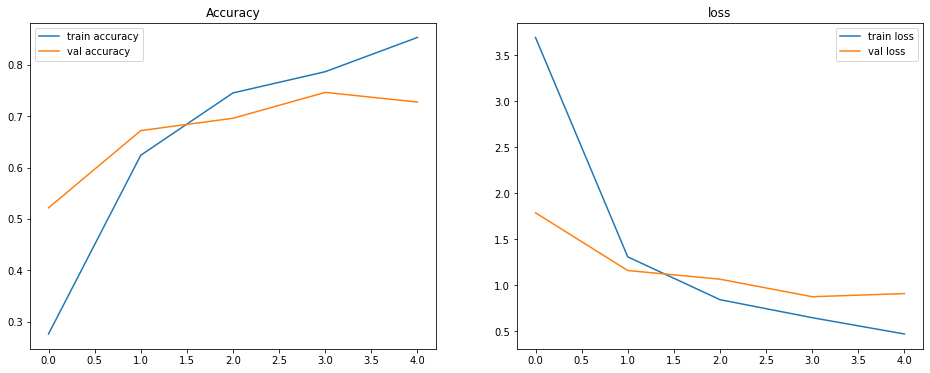

In [ ]:
helper_functions.plot_loss_curves(resnet_model_history)

Tổng quan kiến trúc của resnet_model

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extractor_layer (Ker (None, 1001)              4254889   
_________________________________________________________________
dense (Dense)                (None, 10)                10020     
Total params: 4,264,909
Trainable params: 10,020
Non-trainable params: 4,254,889
_________________________________________________________________


Bạn có thể xem sức mạnh của TensorFlow Hub tại đây. Layer trích xuất thuộc tính có đên 4,254,889 tham số là các mẫu định sẵn mà mô hình đã học được trên tập dữ liệu ImageNet. Vì chúng ta đã đặt trainable = `False`, nên các mẫu này vẫn đóng băng (không thể train) trong quá trình train được. 

Điều này có nghĩa là trong quá trình train, mô hình sẽ chỉ có thể cập nhật  10,020 tham số trong layer trên cùng để xuất ra cho phù hợp với tập dữ liệu.

ResNetV250 đã được train, đến lúc làm điều tương tự với mô hình EfficientNetB0.

### xây dựng mô hình dựa trên EfficientNetB0 

In [ ]:
efficientnet_model = create_model(efficientnet_url)

efficientnet_model.compile(
    loss="categorical_crossentropy", 
    optimizer="adam",
    metrics=["accuracy"]
)

efficientnet_model_history = efficientnet_model.fit(
    train_data,
    steps_per_epoch=len(train_data), 
    epochs=5, 
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[
               create_tensorboard_callback("tensorflow_hub", "efficientB0")
    ]
)

Đã lưu tensorboard callback vào : tensorflow_hub/efficientB0/08092021-172210
Epoch 1/5
24/24 [==============================] - 33s 994ms/step - loss: 1.7190 - accuracy: 0.5080 - val_loss: 1.1768 - val_accuracy: 0.7712
Epoch 2/5
24/24 [==============================] - 19s 816ms/step - loss: 0.9698 - accuracy: 0.7920 - val_loss: 0.7744 - val_accuracy: 0.8376
Epoch 3/5
24/24 [==============================] - 19s 814ms/step - loss: 0.6824 - accuracy: 0.8533 - val_loss: 0.6158 - val_accuracy: 0.8540
Epoch 4/5
24/24 [==============================] - 20s 860ms/step - loss: 0.5398 - accuracy: 0.8880 - val_loss: 0.5372 - val_accuracy: 0.8672
Epoch 5/5
24/24 [==============================] - 20s 858ms/step - loss: 0.4562 - accuracy: 0.9053 - val_loss: 0.4919 - val_accuracy: 0.8736


EfficientNetB0 thậm chí còn học tốt hơn cả ResnetV50, với độ chính xác trên tập dữ liệu train ~90%, và trên tập dữ liệu test >87%. 

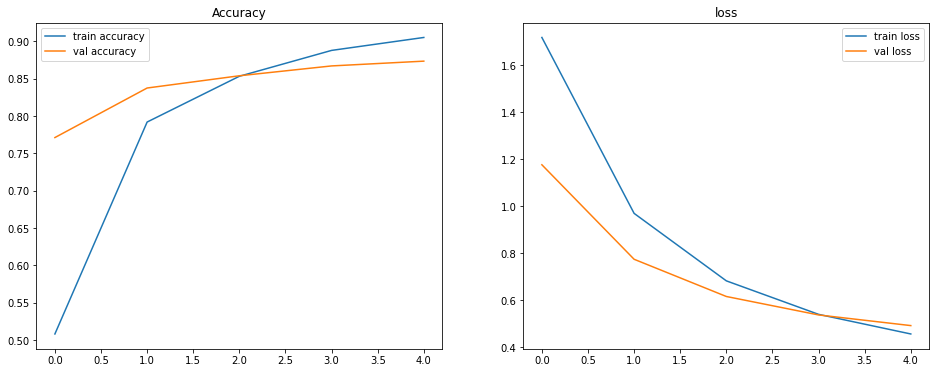

In [ ]:
helper_functions.plot_loss_curves(efficientnet_model_history)

Leaning curves của `EfficientB0` trông có vẻ đi rất song song giữa `train` và `test`. Nếu train lâu hơn, rất có thể mô hình sẽ còn cải thiện tốt hơn. 

Tổng quan kiến trúc mô hình `EfficientB0` 

In [ ]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extractor_layer (Ker (None, 1280)              4049564   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


### xây dựng mô hình dựa trên ImageNet

In [ ]:
imagenet_model = create_model(imagenet_url)

imagenet_model.compile(
    loss="categorical_crossentropy", 
    optimizer="adam",
    metrics=["accuracy"]
)

imagenet_model_history = imagenet_model.fit(
    train_data,
    steps_per_epoch=len(train_data), 
    epochs=5, 
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[
               create_tensorboard_callback("tensorflow_hub", "ImageNet")
    ]
)

Đã lưu tensorboard callback vào : tensorflow_hub/ImageNet/08092021-173100
Epoch 1/5
24/24 [==============================] - 23s 887ms/step - loss: 4.0113 - accuracy: 0.2480 - val_loss: 1.8793 - val_accuracy: 0.4924
Epoch 2/5
24/24 [==============================] - 19s 815ms/step - loss: 1.2777 - accuracy: 0.6160 - val_loss: 1.2334 - val_accuracy: 0.6312
Epoch 3/5
24/24 [==============================] - 19s 823ms/step - loss: 0.8434 - accuracy: 0.7347 - val_loss: 1.1377 - val_accuracy: 0.6760
Epoch 4/5
24/24 [==============================] - 19s 827ms/step - loss: 0.6769 - accuracy: 0.7987 - val_loss: 0.9940 - val_accuracy: 0.7124
Epoch 5/5
24/24 [==============================] - 19s 831ms/step - loss: 0.4613 - accuracy: 0.8560 - val_loss: 0.9108 - val_accuracy: 0.7284


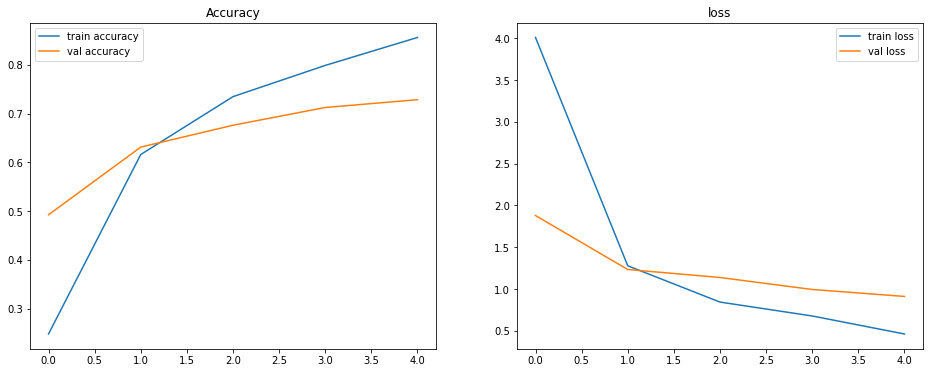

In [ ]:
helper_functions.plot_loss_curves(imagenet_model_history)

In [ ]:
imagenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extractor_layer (Ker (None, 1001)              4254889   
_________________________________________________________________
dense_2 (Dense)              (None, 10)                10020     
Total params: 4,264,909
Trainable params: 10,020
Non-trainable params: 4,254,889
_________________________________________________________________


## 4. Sử dụng tensorboard để so sánh kết quả từ các mô hình

mặc dù chúng ta đã so sánh khả năng học của các mô hình bằng cách xem xét độ chính xác trên các tập dữ liệu `train` và `test`. Nhưng điều gì sẽ xảy ra nếu bạn có nhiều mô hình hơn nữa? Có thể bạn sẽ không thể nhớ được hết tất cả. 

Chính nhờ có sự băn khoăn như vậy, TensorBoard (được cài đặt sẵn trong Google Colab) đã được ra đời.

Điều tốt là, kể từ khi chúng tôi thiết lập lệnh gọi lại TensorBoard, tất cả nhật ký đào tạo của mô hình của chúng ta đã được lưu tự động. Để hình dung, chúng ta có thể upload các kết quả lên [TensorBoard.dev](https://tensorboard.dev/).

> 🔑 **Lưu ý:** Những thử nghiệm này là công khai, đừng upload những dữ liệu nhạy cảm. Bạn có thể xóa các thử nghiệm nếu cần.

### 4.1 Upload các thử nghiệm lên TensorBoard

Để upload một loạt các nhật ký TensorFlow lên TensorBoard, chúng ta có thể sử dụng lệnh sau:

```
Upload TensorBoard dev records

!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \ 
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \ 
  --one_shot
```

Với:
* `--logdir` đường dẫn đến vị trí upload
* `--name` Tên thử nghiệm (bạn có thể đặt tùy ý)
* `--description` Mô tả ngắn gọn về thử nghiệm (Tùy ý)
* `--one_shot` thoát khỏi Tensorboard uploaded sau khi quá trình này hoàn tất

Chạy lệnh `tensorboard_dev_upload` lần đầu sẽ yêu cầu bạn cấp quyền cho phép upload lên TensorBoard.dev. Sau khi bạn đã cho phép upload, quá trình này sẽ bắt đầu thực hiện công việc của upload.

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2 vs ImageNet" \
  --description "Comparing three different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot

2021-09-08 17:47:52.568801: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-08 17:47:52.577161: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-08 17:47:52.577662: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privac

### 4.2 Liệt kê các thử nghiệm đã được lưu trên Tensorboard



In [ ]:
!tensorboard dev list

2021-09-08 17:49:14.483172: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-08 17:49:14.496163: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-08 17:49:14.496706: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
https://tensorboard.dev/experiment/c8Z2nU5fQP61rJ3xHNx6tQ/
	Name                 EfficientNetB0 vs. ResNet50V2 vs ImageNet
	Description          Comparing three different TF Hub feature extraction models architectures using 10% of training images
	Id                   c8Z2nU5fQP61rJ3xHNx6tQ
	Created              2021-09-08 17:48:14 (1 min

### 4.3 Xóa thử nghiệm trong tensorboard

In [ ]:
!tensorboard dev delete --experiment_id NWUkb0ZESPWjLB35PqJjzA

2021-09-08 17:51:57.555890: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-08 17:51:57.564195: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-08 17:51:57.564702: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
Deleted experiment NWUkb0ZESPWjLB35PqJjzA.


Kiểm tra xem đã xóa chưa

In [ ]:
!tensorboard dev list

2021-09-08 17:52:18.801168: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-08 17:52:18.809233: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-08 17:52:18.809749: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
https://tensorboard.dev/experiment/c8Z2nU5fQP61rJ3xHNx6tQ/
	Name                 EfficientNetB0 vs. ResNet50V2 vs ImageNet
	Description          Comparing three different TF Hub feature extraction models architectures using 10% of training images
	Id                   c8Z2nU5fQP61rJ3xHNx6tQ
	Created              2021-09-08 17:48:14 (4 min